<a href="https://colab.research.google.com/github/Stephaaniee/ProjectWork/blob/main/TstTst2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from fastai.vision.all import *
from fastai.data.core import DataLoader
import random
import re
import os
import shutil
import PIL
import torch
import numpy as np
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files
from fastai.data.core import DataLoaders
from fastbook import *
import pathlib
import tensorflow as tf

In [1]:
pip install fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (1

In [3]:
set_seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  #split data
# import splitfolders
# splitfolders.ratio(r'C:\Users\okosa.s\Documents\Project Work\FirstTest\sugar_beets', output="output", seed=1337, ratio=(.8, 0.1,0.1))

In [ ]:
#ensuring the images are the same size , label and augument the data
item_tfms = RandomResizedCrop(460, min_scale = 0.75, ratio=(1., 1.)),
batch_tfms = [*aug_transforms(size = 224, max_warp=0), Normalize.from_stats(*imagenet_stats)] #scaling the image to train faster
bs=64

In [5]:
#Blueprint for how the data is defined
dataTest = DataBlock(
    blocks = (ImageBlock, CategoryBlock), #Datablock class (input, output)
    get_items = get_image_files, #use this function to get the input, output (not restricted to x and y inout when you have more than 2 parameters)
    splitter = RandomSplitter(valid_pct = 0.2, seed= 42), # split dataset when training the dataset
    # get_y = using_attr(RegexLabeller(pat = r'([\w]+).\d+..*$'), 'name'),
    get_y = parent_label, #image labels
    item_tfms = RandomResizedCrop(460, min_scale = 0.75, ratio=(1., 1.)), #Label and augument the transforms
    batch_tfms = [*aug_transforms(size = 224, max_warp=0), Normalize.from_stats(*imagenet_stats)] #scaling the image to train faster
)

In [6]:
dls = dataTest.dataloaders('/content/drive/MyDrive/sugar_beets_DETR', bs=32)#Takes the dataset input, and batch size and applies this to the dataloader
#the item transform occurs on the CPU , and batch transform occurs after the item transform on the GPU

In [7]:
dls.vocab #to view classes
# dls.vocab.o2i #converts the strings to numerical values during train

['healthy', 'sick']

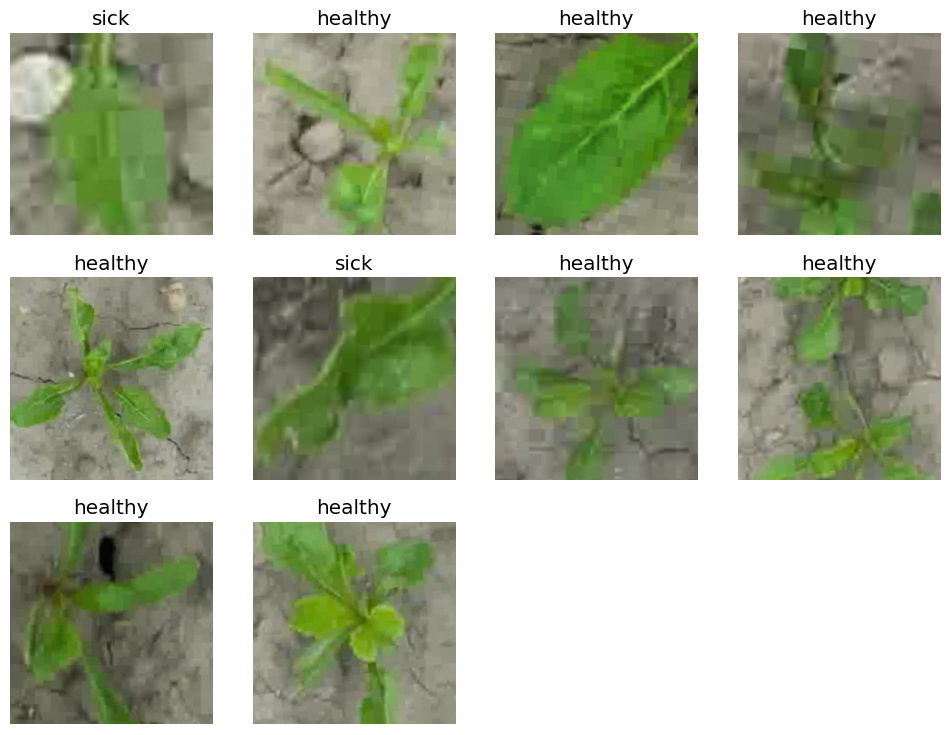

In [8]:
dls.show_batch(max_n=10)

In [9]:
learn = vision_learner(dls, resnet34, metrics = error_rate)
#uses the crossEntropyFlat loss function, AdamW optimizer in training our model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 148MB/s]


In [11]:
learn.fit_one_cycle(5) # iterate over the data in 5 cycles

epoch,train_loss,valid_loss,error_rate,time
0,0.510181,0.334075,0.132251,28:22
1,0.325164,0.283363,0.109919,02:34
2,0.279255,0.262518,0.107309,02:36
3,0.260516,0.263394,0.105568,02:35
4,0.250178,0.263252,0.108759,02:36


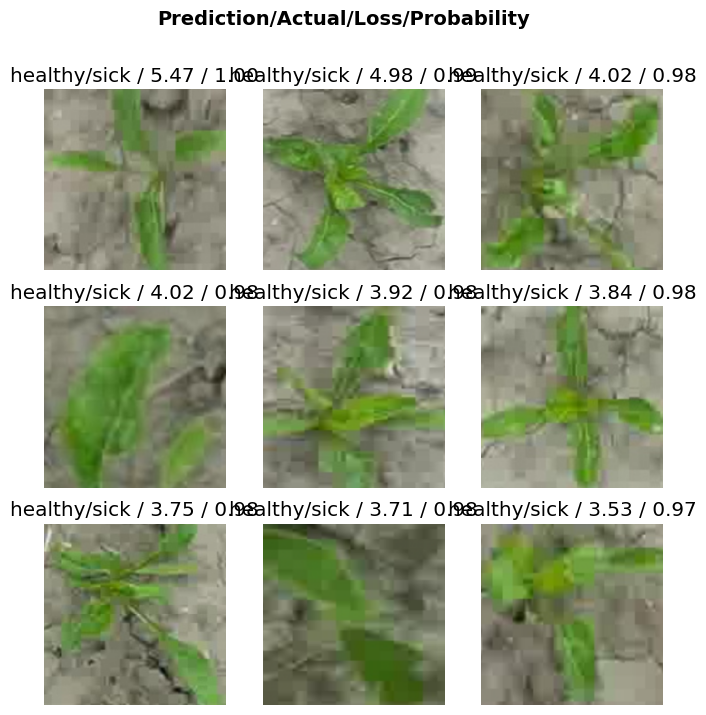

In [12]:
# Analyse how the model performed
results = ClassificationInterpretation.from_learner(learn)
#takes the function plot_top losses and shows the 9 top losses
results.plot_top_losses(9, figsize = (8, 8)) #This shows the probability of the losses

In [13]:
learn.save('TST_DETR')

Path('models/TST_DETR.pth')

[('sick', 'healthy', 269), ('healthy', 'sick', 106)]

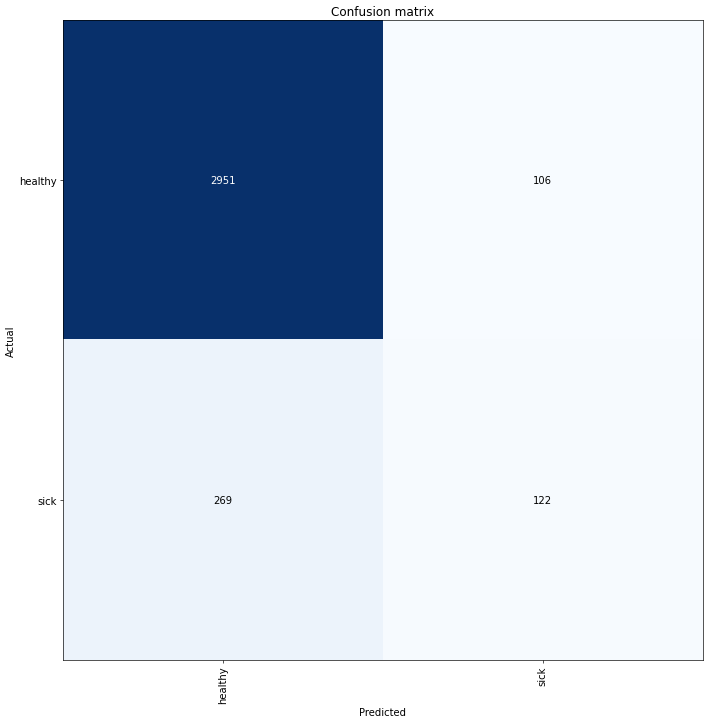

In [15]:
#confusion matrix to understand how the model is behaving with respect to the real data
results.plot_confusion_matrix(figsize=(12,12), dpi=60) #(The diagonal values are the actual recognized values)
 #The most confussed dataset in the model in this case 3
results.most_confused(min_val=3)

In [16]:

#Finetuning the model
learn.load('TST_DETR')

In [17]:
learn.unfreeze
#Train the entire model not only the last layer of the model

<bound method Learner.unfreeze of <fastai.learner.Learner object at 0x7a3e14a82a10>>

SuggestedLRs(valley=1.737800812406931e-05)

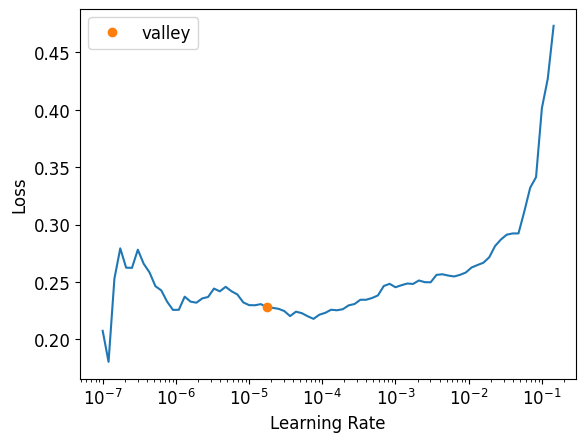

In [18]:
learn.lr_find()
#Find the ideal lr of the model

In [19]:
learn.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.267831,0.262810,0.109339,02:52
1,0.241459,0.257730,0.106148,02:36
2,0.256706,0.262050,0.109919,02:38
3,0.249970,0.258409,0.105858,02:39


In [20]:
learn.save('TST_DETR_OPTIMIZED')

Path('models/TST_DETR_OPTIMIZED.pth')

In [ ]:
# https://medium.com/@FastAIButMakeItSlow/image-classification-using-fastai-dogs-vs-cats-project-bbe752a4bcf8
# https://course18.fast.ai/lessons/lesson1.html
# https://www.youtube.com/watch?v=93kXzUOiYY4
# https://walkwithfastai.com/revisited/pets.html